In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np


[*********************100%***********************]  1 of 1 completed


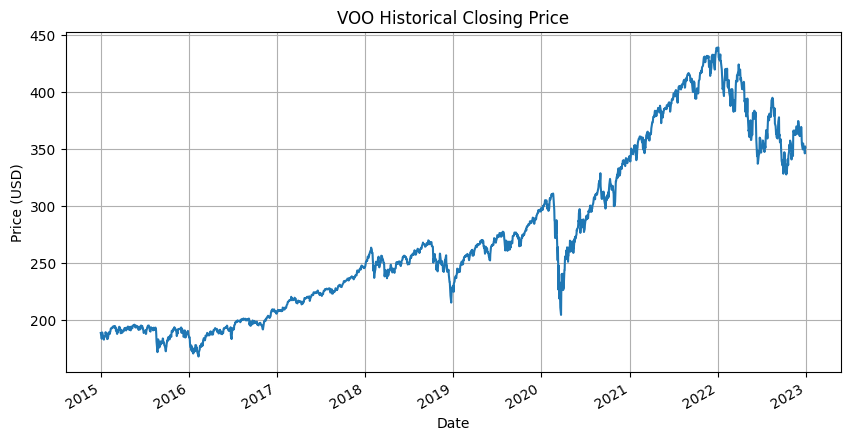

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.01e+03 |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 342      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.01e+03    |
|    ep_rew_mean          | 0           |
| time/                   |             |
|    fps                  | 317         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013751732 |
|    clip_fraction        | 0.289       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Fetch historical data for VOO
symbol = "VOO"
start_date = "2015-01-01"
end_date = "2023-01-01"

# Use yfinance to download data
df = yf.download(symbol, start=start_date, end=end_date)

# Save data to CSV for easier access
df.to_csv("voo_data.csv")

# Quick visualization of the closing price
df['Close'].plot(figsize=(10, 5))
plt.title(f"{symbol} Historical Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()
plt.show()

# Define custom trading environment
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index()  # Ensure the index is integer based
        self.current_step = 0
        self.cash = 10000  # Starting cash
        self.stock_owned = 0
        
        # Define action and observation space
        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)
        # Observation space: [normalized_cash, normalized_stock_owned, normalized_closing_price]
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.cash = 10000
        self.stock_owned = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        current_price = self.df.iloc[self.current_step]['Close']
        normalized_cash = self.cash / 10000
        normalized_stock_owned = self.stock_owned / 100
        normalized_price = current_price / 1000
        obs = np.array([normalized_cash, normalized_stock_owned, normalized_price], dtype=np.float32)
        return obs
    
    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        prev_cash = self.cash
        prev_stock_owned = self.stock_owned
        
        # Execute action
        if action == 1:  # Buy
            if self.cash >= current_price:
                self.stock_owned += 1
                self.cash -= current_price
        elif action == 2:  # Sell
            if self.stock_owned > 0:
                self.stock_owned -= 1
                self.cash += current_price
        
        # Advance to the next step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        
        # Calculate reward as percentage change in asset value
        current_asset_value = self.cash + self.stock_owned * current_price
        prev_asset_value = prev_cash + prev_stock_owned * current_price
        reward = (current_asset_value - prev_asset_value) / prev_asset_value if prev_asset_value > 0 else 0
        
        terminated = done
        truncated = False
        
        return self._next_observation(), reward, terminated, truncated, {}
    
    def render(self, mode='human', close=False):
        profit = self.cash + self.stock_owned * self.df.iloc[self.current_step]['Close'] - 10000
        print(f'Step: {self.current_step}, Cash: {self.cash}, Stock Owned: {self.stock_owned}, Profit: {profit}')

# Instantiate the environment
env = TradingEnv(df)

# Check if the environment follows the gym interface properly
check_env(env, warn=True)

# Train the agent using PPO
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

# Test the trained model
obs, _ = env.reset()
for _ in range(10):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break

In [7]:
import numpy as np
import pygame
import random

# Parameters
gamma = 0.95  # Discount factor
alpha = 0.1   # Learning rate
epsilon = 0.1 # Exploration rate
episodes = 20

grid_size = (5, 5)
cheese_reward = 10
cat_penalty = -10
empty_reward = 0

# Environment Setup
environment = np.array([
    [-1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 2],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0]
])

# Actions
actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
action_vectors = {
    'UP': (-1, 0),
    'DOWN': (1, 0),
    'LEFT': (0, -1),
    'RIGHT': (0, 1)
}

# Q-Table Initialization
Q = np.zeros((grid_size[0], grid_size[1], len(actions)))

# Pygame Initialization
pygame.init()
window_size = 500
tile_size = window_size // grid_size[0]
screen = pygame.display.set_mode((window_size, window_size))
pygame.display.set_caption('Mouse and Cheese with Q-Learning')

# Colors
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
YELLOW = (255, 255, 0)
BLACK = (0, 0, 0)

# Draw the environment
def draw_environment(mouse_pos, cat_pos):
    screen.fill(WHITE)
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            rect = pygame.Rect(col * tile_size, row * tile_size, tile_size, tile_size)
            if environment[row][col] > 0:
                pygame.draw.rect(screen, YELLOW, rect)
            pygame.draw.rect(screen, BLACK, rect, 1)
    # Draw the cat
    cat_rect = pygame.Rect(cat_pos[1] * tile_size, cat_pos[0] * tile_size, tile_size, tile_size)
    pygame.draw.rect(screen, RED, cat_rect)
    # Draw the mouse
    mouse_rect = pygame.Rect(mouse_pos[1] * tile_size, mouse_pos[0] * tile_size, tile_size, tile_size)
    pygame.draw.rect(screen, GREEN, mouse_rect)
    pygame.display.flip()

# Q-Learning Algorithm
def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, len(actions) - 1)
    else:
        return np.argmax(Q[state[0], state[1], :])

def update_q_table(state, action, reward, next_state):
    best_next_action = np.max(Q[next_state[0], next_state[1], :])
    Q[state[0], state[1], action] = (1 - alpha) * Q[state[0], state[1], action] + alpha * (reward + gamma * best_next_action)

# Main Loop
def main():
    for episode in range(episodes):
        mouse_pos = (4, 4)  # Starting position of the mouse
        cat_pos = (0, 0)    # Starting position of the cat
        done = False
        total_reward = 0

        while not done:
            draw_environment(mouse_pos, cat_pos)
            state = mouse_pos
            action_index = choose_action(state)
            action = actions[action_index]
            next_pos = (state[0] + action_vectors[action][0], state[1] + action_vectors[action][1])

            # Ensure mouse stays within bounds
            if next_pos[0] < 0 or next_pos[0] >= grid_size[0] or next_pos[1] < 0 or next_pos[1] >= grid_size[1]:
                next_pos = state

            # Get reward for the next position
            if next_pos == cat_pos:
                reward = cat_penalty
                done = True
            else:
                reward = environment[next_pos[0], next_pos[1]]
                if reward > 0:
                    done = True  # Stop when cheese is eaten

            # Update Q-Table
            update_q_table(state, action_index, reward, next_pos)
            total_reward += reward

            # Update mouse position
            mouse_pos = next_pos

            # Control the speed of visualization
            pygame.time.delay(200)

        print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    pygame.quit()

if __name__ == "__main__":
    main()

Episode 1: Total Reward: 2
Episode 2: Total Reward: 2
Episode 3: Total Reward: 2
Episode 4: Total Reward: 2
Episode 5: Total Reward: 2
Episode 6: Total Reward: 2
Episode 7: Total Reward: 2
Episode 8: Total Reward: 2
Episode 9: Total Reward: 2
Episode 10: Total Reward: 2
Episode 11: Total Reward: 2
Episode 12: Total Reward: 2
Episode 13: Total Reward: 2
Episode 14: Total Reward: 2
Episode 15: Total Reward: 2
Episode 16: Total Reward: 2
Episode 17: Total Reward: 2
Episode 18: Total Reward: 2
Episode 19: Total Reward: 2
Episode 20: Total Reward: 2


In [9]:
import pandas as pd
# Generate a sample data frame and one hot encode the categorical features
data = {
    'category': ['A', 'B', 'C', 'A', 'C'],
    'value': [10, 20, 30, 40, 50]
}

df = pd.DataFrame(data)

# One hot encode the 'category' column
df_encoded = pd.get_dummies(df, columns=['category'], dtype=int)


c:\Users\hsingh\OneDrive - INVIDI Technologies Corp\machine learning\machine-learning\myenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desc to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desc` for environment variables or `env.get_wrapper_attr('desc')` that will search the reminding wrappers.
  logger.warn(


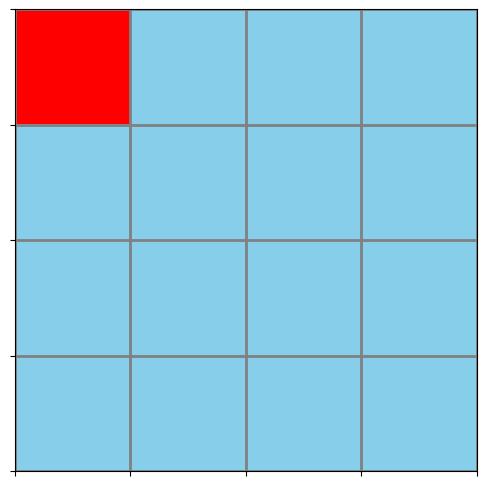

KeyboardInterrupt: 

In [14]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import matplotlib.colors as mcolors

# Set up the FrozenLake environment (non-slippery version)
env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="ansi")

# Q-learning parameters
learning_rate = 0.8
discount_factor = 0.95
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01

episodes = 5000
max_steps = 100

env.reset()

# Initialize the Q-table
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
q_table = np.zeros((state_space_size, action_space_size))

def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore: choose a random action
    else:
        return np.argmax(q_table[state, :])  # Exploit: choose the best action from Q-table

# Training the agent
rewards = []

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        action = choose_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Update Q-table using the Bellman equation
        q_value = q_table[state, action]
        max_future_q = np.max(q_table[next_state, :])
        new_q_value = (1 - learning_rate) * q_value + learning_rate * (reward + discount_factor * max_future_q)
        q_table[state, action] = new_q_value

        state = next_state
        total_reward += reward

        if done:
            break

    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    rewards.append(total_reward)

    # Print progress
    if (episode + 1) % 500 == 0:
        print(f"Episode: {episode + 1}, Average Reward: {np.mean(rewards[-500:])}")

# Plotting the training rewards
plt.plot(range(episodes), rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards for Q-Learning on FrozenLake")
plt.show()

# Visualize the learned policy
def visualize_policy(q_table):
    action_mapping = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}
    policy = []
    for state in range(state_space_size):
        best_action = np.argmax(q_table[state])
        policy.append(action_mapping[best_action])
    
    print("\nOptimal Policy for Frozen Lake:")
    for i in range(0, len(policy), 4):
        print(policy[i:i + 4])

visualize_policy(q_table)

# Test the trained agent with visualization
def visualize_agent_play():
    state, _ = env.reset()
    done = False
    steps = 0

    print("\nAgent Playing the Game:")
    time.sleep(1)

    while not done and steps < max_steps:
        clear_output(wait=True)
        visualize_environment(state)
        action = np.argmax(q_table[state, :])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        steps += 1
        time.sleep(0.5)
    
    clear_output(wait=True)
    visualize_environment(state)

def visualize_environment(state):
    grid = np.array(list(env.desc.flatten()), dtype=str).reshape((4, 4))
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = mcolors.ListedColormap(['skyblue', 'black', 'lime', 'gold'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    grid_map = np.zeros_like(grid, dtype=int)

    for i in range(4):
        for j in range(4):
            if grid[i, j] == b'S':
                grid_map[i, j] = 2  # Starting point (lime)
            elif grid[i, j] == b'G':
                grid_map[i, j] = 3  # Goal point (gold)
            elif grid[i, j] == b'H':
                grid_map[i, j] = 1  # Hole (black)
            else:
                grid_map[i, j] = 0  # Frozen tiles (skyblue)

    # Mark agent position
    agent_row, agent_col = divmod(state, 4)
    grid_map[agent_row, agent_col] = 4

    ax.imshow(grid_map, cmap=cmap, norm=norm)
    ax.set_xticks(np.arange(-.5, 4, 1))
    ax.set_yticks(np.arange(-.5, 4, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which="both", color='grey', linestyle='-', linewidth=2)

    # Draw text in each cell
    for i in range(4):
        for j in range(4):
            if grid[i, j] == b'S':
                ax.text(j, i, 'S', ha='center', va='center', color='white', fontsize=16)
            elif grid[i, j] == b'G':
                ax.text(j, i, 'G', ha='center', va='center', color='black', fontsize=16)
            elif grid[i, j] == b'H':
                ax.text(j, i, 'H', ha='center', va='center', color='white', fontsize=16)
            elif (i, j) == (agent_row, agent_col):
                ax.text(j, i, 'A', ha='center', va='center', color='red', fontsize=16)

    plt.show()

# Visualize the agent playing the game for a few episodes
test_episodes = 3
for episode in range(test_episodes):
    print(f"\nTest Episode {episode + 1}")
    visualize_agent_play()